# Distinguishing muffins and Chihuahuas with NNs

The aim of this project is to train a neural network for the binary classification of muffins and Chihuahuas based on the images contained in the relative [Kaggle dataset](https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification).

# Setup

In [3]:
import importlib
import pip

def import_or_install(package_name, alias=None):
    try:
        imported_package = importlib.import_module(package_name)
        if alias:
            globals()[alias] = imported_package
        print(f"{package_name} is already installed.")
    except ImportError:
        import subprocess
        print(f"{package_name} is not installed. Installing...")
        subprocess.check_call(['pip', 'install', package_name])
        imported_package = importlib.import_module(package_name)
        if alias:
            globals()[alias] = imported_package
        print(f"{package_name} has been installed.")

c:\Users\lucia\anaconda3\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


We import the dataset from Kaggle, using a token.

In [4]:
import os

os.environ['KAGGLE_USERNAME'] = "luciaannamellini"
os.environ['KAGGLE_KEY'] = "c209fcf223ecdd6be8fd373196354f4b"

import_or_install("kaggle")

from kaggle.api.kaggle_api_extended import KaggleApi

FOLDERNAME = "muffin-vs-chihuahua-image-classification"
PATH = "./"

api = KaggleApi()
api.authenticate()
api.dataset_download_files("samuelcortinhas/muffin-vs-chihuahua-image-classification", PATH)

kaggle is already installed.


In [ ]:
import zipfile

with zipfile.ZipFile(PATH + FOLDERNAME + ".zip", 'r') as zip_ref:
    zip_ref.extractall(FOLDERNAME)
os.remove(PATH + FOLDERNAME +".zip")

If already present we import, or otherwise we install, the `tensorflow` package. Above all functionalities we will be using the `keras` module to construct neural networks to distinguish the images in the dataset.

In [ ]:
import_or_install("tensorflow","tf")

tensorflow is already installed.


# Data pre-processing

Before proceeding we remove badly encoded images.

In [ ]:
from PIL import Image
def remove_badly_encoded_images(directory):
    for filename in os.listdir(directory):
        if filename.endswith('.JPG'):
            try:
                img = Image.open(directory+filename)  # open the image file
                img.verify()  # verify that it is, in fact an image
                img.close()
            except (IOError, SyntaxError):
                os.remove(directory+filename)

deleted = remove_badly_encoded_images(PATH + FOLDERNAME + "/")
print("Deleted images:",deleted)

Deleted images: None


We begin by subdividing the dataset into training and test set. This partition is provided by the Kaggle dataset itself, with $\frac{1}{5}$ of the images assigned to the test set.

We also infer the binary labels from the layout of the dataset. Specifically the labels are assigned as follows:
\begin{equation*}
    \begin{cases}
        0  & \text{chihuahua} \\
        1  & \text{muffin}
    \end{cases}
\end{equation*}

In [ ]:
def create_dataset(foldername):
    dataset_path = os.path.join(PATH, FOLDERNAME, foldername)
    return tf.keras.utils.image_dataset_from_directory(dataset_path, labels = "inferred")

print("Training set:")
train_ds = create_dataset("train")
print("Test set")
test_ds = create_dataset("test")

Training set:
Found 4733 files belonging to 2 classes.
Test set
Found 1184 files belonging to 2 classes.


Let's give a look at a small sample of pictures with the relative annotations.

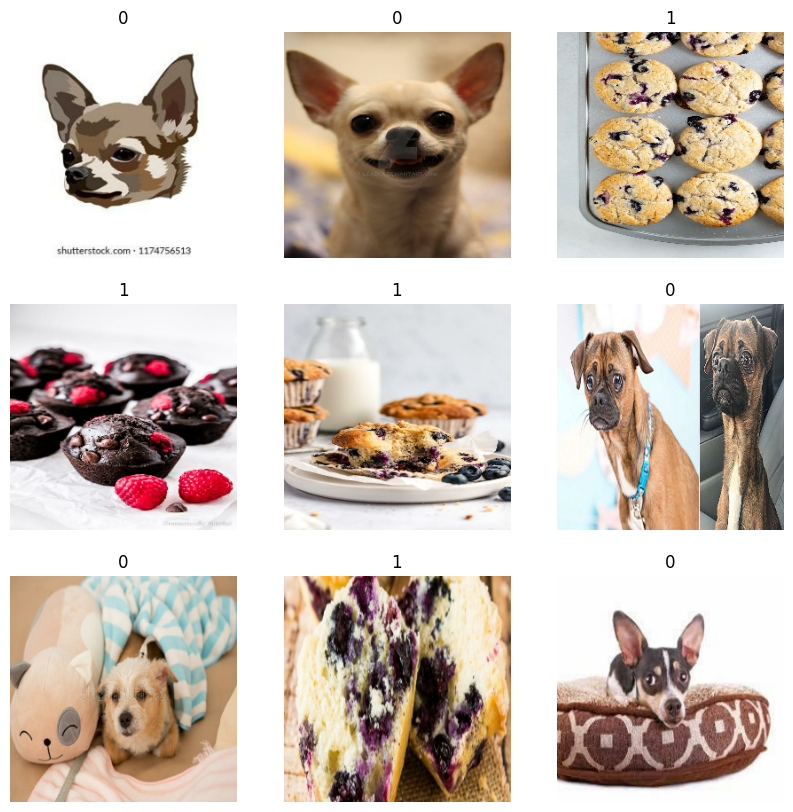

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Before diving into the actual pre-processing of the data we prepare a function that produces realistic variations of the images in the dataset. This data augmentation step is useful to make a small dataset more expressive by introducing random changes, so counteracting overfitting.

In [ ]:
from keras import layers

def data_augmentation(images, data_augmentation_layers, training = True):
    for layer in data_augmentation_layers:
        images = layer(images, training = training)
    return images

For example we may randomly flip the picture or slightly tilt it. We show here the potential results of the data augmentation function.

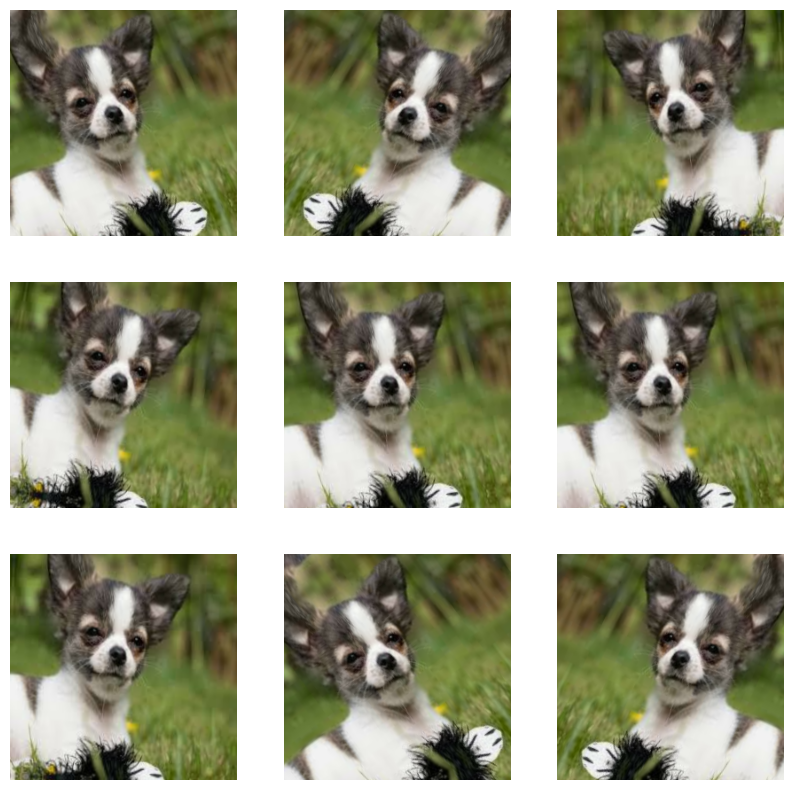

In [ ]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images, data_augmentation_layers, training=True)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

To make learning easer we simplify the images by:
* taking them in grayscale,
* reducing their dimensions by resizing them to the size $(64,64)$.

In [ ]:
def rgb_to_grayscale(image):
    grayscale_image = tf.image.rgb_to_grayscale(image)
    return grayscale_image

def resize_image(image, target_size):
    resized_image = tf.image.resize(image, target_size)
    return resized_image


image_size = (64,64)

preprocess = {
    'rgb_to_grayscale': lambda x, y: (rgb_to_grayscale(x),y),
    'resize_image': lambda x,y: (resize_image(x, image_size),y)
}

for func_name, func in preprocess.items():
    train_ds = train_ds.map(func)
    test_ds = test_ds.map(func)

Also, for the reasons stated before, we substitute each of the images in the training set with it's augmented version.

In [ ]:
def augment_dataset(dataset, data_augmentation_function):
    dataset.map(data_augmentation_function)

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, data_augmentation_layers, training=True), y))

# Model construction

To try and classify the images in the dataset we build various neural network models, and store them in the `models_configs` dictionary. For the moment we prepare the structure of each neural network, and other parameters, like `optimizer`, `loss` and `metrics`, that will be needed to build (compile) the models.

Also, instead of fixing the values that characterize the layers of the models, we have used hyperparameters placeholders. We have opted for an object of type `HyperParameter`, that allows to specify the type and domain for the desired value. These parameters will be tuned in a later step.

In [ ]:
from tensorflow.keras import models

input_shape = train_ds.element_spec[0].shape[1:]

import_or_install('keras_tuner','kt')

hp = kt.HyperParameters()
models_configs = {}

keras_tuner is already installed.


In the next sections we display the parameters for each of the models, and a visual represenation of the layes that make up each neural network.

## Model 1

In [ ]:
models_configs['model_1'] = {
    'build_model': models.Sequential([
        layers.Input(shape = input_shape, name = 'input'),
        layers.Conv2D(hp.Choice('filters_1', [16, 32, 64]), np.array(hp.Choice('kernel_size_1',range(3,6))).repeat(2), activation='relu', name = 'convolutional_1'),
        layers.MaxPooling2D(np.array(hp.Choice('pool_size_1', range(2,5))).repeat(2), name = 'maxPooling_1'),
        layers.Conv2D(hp.Choice('filters_2', [16, 32, 64]), np.array(hp.Choice('kernel_size_2',range(3,6))).repeat(2), activation='relu', name = 'convolutional_2'),
        layers.MaxPooling2D(np.array(hp.Choice('pool_size_2', range(2,5))).repeat(2), name = 'maxPooling_2'),
        layers.Dense(hp.Choice('units',[32,64,96]), activation='relu', name = 'dense_1'),
        layers.Dense(1, activation='sigmoid', name = 'output')
        ]),
    'tuner_directory': 'tuners',
    'project_name': 'model_1',
    'optimizer': 'adam',
    'loss': 'binary_crossentropy',
    'metrics': ['accuracy']
    }

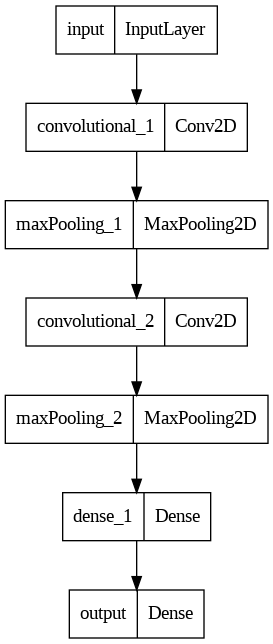

In [ ]:
tf.keras.utils.plot_model(models_configs['model_1']['build_model'])

The first, simpler model, is composed by two convolutional layers, ideal for detecting patterns in images. Also, each of the convolutional layers is followed by max pooling layers, with the aim of summarizing the information extracted by passing a kernel over the images multiple times, as prescribe by the `filters` parameter.

After the first feature learning stage follows a dense layer, to connect the patterns found in the images to the desired output. Finally, the last output layer is designed to summarize this information into a unique value in the interval $\left[0,1\right]$.

## Model 2

In [ ]:
models_configs['model_2'] = {
        'build_model': models.Sequential([
            layers.Input(shape = input_shape, name = 'input'),
            layers.Conv2D(hp.Choice('filters_1', [16, 32, 64]), np.array(hp.Choice('kernel_size_1',range(3,6))).repeat(2), activation='relu', name = 'convolutional_1'),
            layers.MaxPooling2D(np.array(hp.Choice('pool_size_1', range(2,5))).repeat(2), name = 'maxPooling_1'),
            layers.Conv2D(hp.Choice('filters_2', [16, 32, 64]), np.array(hp.Choice('kernel_size_2',range(3,6))).repeat(2), activation='relu', name = 'convolutional_2'),
            layers.MaxPooling2D(np.array(hp.Choice('pool_size_2', range(2,5))).repeat(2), name = 'maxPooling_2'),
            layers.Conv2D(hp.Choice('filters_3', [16, 32, 64]), np.array(hp.Choice('kernel_size_1',range(3,6))).repeat(2), activation='relu', name = 'convolutional_3'),
            layers.Dense(hp.Choice('units',[32,64,96]), activation='relu', name = 'dense_1'),
            layers.Dense(1, activation='sigmoid', name = 'output')
            ]),
        'tuner_directory': 'tuners',
        'project_name': 'model_2',
        'optimizer': 'adam',
        'loss': 'binary_crossentropy',
        'metrics': ['accuracy']
    }

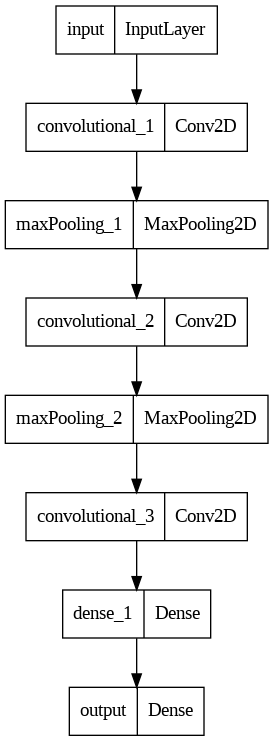

In [ ]:
tf.keras.utils.plot_model(models_configs['model_2']['build_model'])

For this model we wanted to study the quality of the prediction obtained by adding an additional pair of convolutional and max pooling layers.

## Model 3

In [ ]:
models_configs['model_3'] = {
        'build_model': models.Sequential([
            layers.Input(shape = input_shape, name = 'input'),
            layers.Conv2D(hp.Choice('filters_1', [16, 32, 64]), np.array(hp.Choice('kernel_size_1',range(3,6))).repeat(2), activation='relu', name = 'convolutional_1'),
            layers.MaxPooling2D(np.array(hp.Choice('pool_size_1', range(2,5))).repeat(2), name = 'maxPooling_1'),
            layers.Conv2D(hp.Choice('filters_2', [16, 32, 64]), np.array(hp.Choice('kernel_size_2',range(3,6))).repeat(2), activation='relu', name = 'convolutional_2'),
            layers.MaxPooling2D(np.array(hp.Choice('pool_size_2', range(2,5))).repeat(2), name = 'maxPooling_2'),
            layers.Flatten(name = 'flatten'),
            layers.Dense(hp.Choice('units',[32,64,96]), activation='relu', name = 'dense_1'),
            layers.Dense(1, activation='sigmoid', name = 'output')
            ]),
        'tuner_directory': 'tuners',
        'project_name': 'model_2',
        'optimizer': 'adam',
        'loss': 'binary_crossentropy',
        'metrics': ['accuracy']
    }

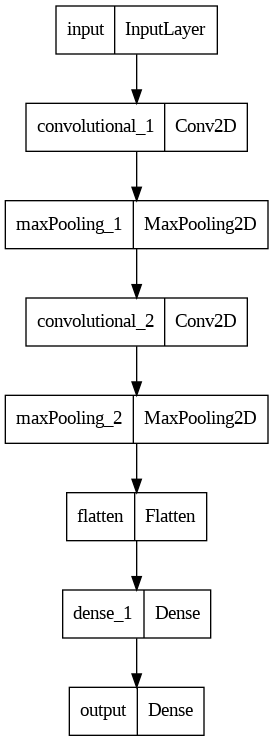

In [ ]:
tf.keras.utils.plot_model(models_configs['model_3']['build_model'], show_shapes= True)s

Lastly, we were curious to see the effect of inserting a flattening layer between extracting image features and relating such patterns to the classification problem. By flattening the results of the convolutional networks we are reducing the expressivity of the foundings, but we are also simplifying the task left for the two last layers.

## Hyperparameter tuning

Now that we have outlined the structure of the neural networks we choose the hyperparameters for each layer. Specifically we are looking to valorize the following parameters:
* convolutional layers (type `Conv2D`)
    * number of filters
    * size of the kernels, square in shape
* max pooling layers (type `MaxPooling2D`)
    * size of the pool
* dense layers that are no output layers (type `Dense`)
    * number of 
    
To do this we use the `keras_tune` library @cite, that allows hyperparameter tuning. It allows to build a `Tuner` object based on a compiled Keras model that has as argument a `Hyperparameter` object. Such a tuner can then search for the best possible hyperparameters for the model and value domains that have been supplied. For efficiency reasons we have opted for a random search in the hyperparameter space, in fact we have set the `max_trials` option such that only a portion of the combinations of hyperparameters will be evaluated.   
The tuner also acts as a log for the hyperparameter combinations that have ben tested, that will become useful in the experiment section.

In [ ]:
def hyperparameter_tuning(model, train_ds, test_ds, directory, project_name):
    tuner = kt.RandomSearch(
        model,
        max_trials=10,
        directory=directory,
        project_name=project_name)

    tuner.search(train_ds,
                 epochs=5,
                 validation_data=test_ds)

    return tuner

In [ ]:
for model in models_configs:
    model_configs = models_configs[model]
    model_configs['build_model'].compile(optimizer = model_configs['optimizer'], loss = model_configs['loss'], metrics = model_configs['metrics'])
    tuner_directory = model_configs['tuner_directory']
    project_name = model_configs['project_name']
    tuner = hyperparameter_tuning(lambda hp: model_configs['build_model'], train_ds, test_ds, tuner_directory, project_name)
    best_hps = tuner.get_best_hyperparameters()[0]
    best_model = tuner.hypermodel.build(best_hps)

NameError: name 'models_configs' is not defined

# Experiments

# Results